required packages and libraries:

In [1]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain-huggingface langchain-google-genai
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install


post processing function for annotating the screenshot of the web page with the help of Omniparser Space API on Huggingface

In [2]:
import tempfile, re, ast
from gradio_client import Client, handle_file
from PIL import Image

def process_screenshot(screenshot_bytes: bytes):
    """
    → screenshot_bytes: raw PNG bytes (exactly what page.screenshot() gives)
    ← returns (annotated_png: bytes, icons: List[dict])
    """
    # dump the input bytes to disk so gradio_client can use it
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        tmp.write(screenshot_bytes)
        tmp_path = tmp.name

    # call the Space
    client = Client("microsoft/OmniParser-v2")
    annotated_path, raw_text = client.predict(
        image_input=handle_file(tmp_path),
        box_threshold=0.1,
        iou_threshold=0.1,
        use_paddleocr=True,
        imgsz=640,
        api_name="/process"
    )

    # read back the annotated image as raw PNG bytes
    with open(annotated_path, "rb") as f:
        annotated_png = f.read()

    # parse the icons out of the text
    img = Image.open(annotated_path)
    w, h = img.size
    icons = []
    for raw in re.findall(r"icon \d+: (\{.*?\})", raw_text):
        d = ast.literal_eval(raw)
        x1, y1, x2, y2 = d["bbox"]
        icons.append({
            "x": int((x1 + x2)/2 * w),
            "y": int((y1 + y2)/2 * h),
            "interactivity": str(d["interactivity"]).lower(),
            "content": d["content"]
        })

    return annotated_png, icons


in case of colab running run cell below:

In [3]:
import nest_asyncio
nest_asyncio.apply()

defining graph states which provides the inputs for nodes of graph.

In [4]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    content: str
    interactivity: str



class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    scratchpad: List[BaseMessage] # A system message (or messages) containing the intermediate steps
    observation: str  # The most recent response from a tool

In [5]:
import asyncio
import platform


async def to_url(state: AgentState):
    page = state["page"]
    url_args = state["prediction"]["args"]
    if url_args is None or len(url_args) != 1:
        return f"Failed to navigate to the given url: {url_args}"
    print(url_args[0])
    await page.goto(url_args[0])
    return f"Navigated to {url_args[0]}"

async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]

    await page.mouse.click(x, y)

    return f"Clicked {bbox_id}"




async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":

        scroll_amount = 300
        scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
        await page.mouse.wheel(0, scroll_direction)

    else:
        # Scrolling within a specific element
        scroll_amount = 150
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


In [6]:
import base64
from langchain_core.runnables import chain as chain_decorator

@chain_decorator
async def annotate_page(page: Page, delay: float = 5.0):
    # 1️⃣  hard sleep
    await asyncio.sleep(delay)

    #  –OR–  2️⃣ wait for the browser ‘load’ / ‘networkidle’ event
    # await page.wait_for_load_state("networkidle", timeout=int(delay * 1000))

    #  –OR–  3️⃣ wait for a specific selector you know must exist
    # await page.wait_for_selector("body", state="attached", timeout=int(delay * 1000))
    screenshot = await page.screenshot()
    _png,bboxes = process_screenshot(screenshot)
    print(bboxes)

    return {
        "img": base64.b64encode(_png).decode(),
        "bboxes": bboxes,
    }


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
#from langchain_huggingface import HuggingFacePipeline,ChatHuggingFace
from langchain_google_genai import ChatGoogleGenerativeAI


async def annotate(state):
    marked_page = await annotate_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = ""
        if not text.strip():
            text = bbox["content"]
        interactiviy_type = bbox.get("interactivity")
        labels.append(f'{i} (interactivity: {interactiviy_type}): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    print(text)
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}



In [8]:
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    ImagePromptTemplate,
)
from langchain_core.prompts.prompt import PromptTemplate

# 1. Define the system message template
system_template = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=[],
        template=(
            "Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. "
            "In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. "
            "This screenshot will\nfeature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual\n"
            "information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow\n"
            "the guidelines and choose one of the following actions:\n\n"
            "1. Click a Web Element.\n"
            "2. Delete existing content in a textbox and then type content.\n"
            "3. Scroll up or down.\n"
            "4. Wait \n"
            "5. Go back\n"
            "7. Go to the desired website if you know the exact url or go to google to start over.\n"
            "8. Respond with the final answer\n\n"
            "Correspondingly, Action should STRICTLY follow the format:\n\n"
            "- Click [Numerical_Label] \n"
            "- Type [Numerical_Label]; [Content] \n"
            "- Scroll [Numerical_Label or WINDOW]; [up or down] \n"
            "- Wait \n"
            "- GoBack\n"
            "- ToURL [url]\n"
            "- ANSWER; [Content]\n\n"
            "Key Guidelines You MUST follow:\n\n"
            "* Action guidelines *\n"
            "1) Execute only one action per iteration.\n"
            "2) When clicking or typing, ensure to select the correct bounding box.\n"
            "3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.\n\n"
            "* Web Browsing Guidelines *\n"
            "1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages\n"
            "2) Select strategically to minimize time wasted.\n\n"
            "Your reply should strictly follow the format:\n\n"
            "Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}\n"
            "Action: {{One Action format you choose}}\n"
            "Then the User will provide:\n"
            "Observation: {{A labeled screenshot Given by User}}"
        )
    )
)

# 2. Placeholder for scratchpad
scratchpad = MessagesPlaceholder(variable_name="scratchpad")

# 3. Define the human message template (all prompts in one)
human_template = HumanMessagePromptTemplate(
    prompt=[
        ImagePromptTemplate(
            input_variables=["img"],
            template={"url": "data:image/png;base64,{img}"}
        ),
        PromptTemplate(
            input_variables=["bbox_descriptions"],
            template="{bbox_descriptions}"
        ),
        PromptTemplate(
            input_variables=["input"],
            template="{input}"
        ),
    ]
)

# 4. Build the ChatPromptTemplate manually
manual_prompt = ChatPromptTemplate(
    input_variables=["bbox_descriptions", "img", "input"],
    partial_variables={"scratchpad": []},
    optional_variables=["scratchpad"],
    messages=[system_template, scratchpad, human_template]
)

# from langchain_core.prompts.chat import (
#     ChatPromptTemplate,
#     SystemMessagePromptTemplate,
#     HumanMessagePromptTemplate,
#     MessagesPlaceholder,
#     ImagePromptTemplate,
# )
# from langchain_core.prompts.prompt import PromptTemplate

# # 1. Define the system message template
# system_template = SystemMessagePromptTemplate(
#     prompt=PromptTemplate(
#         input_variables=[],
#         template=(
#             "You are an expert, autonomous web agent. Your primary purpose is to navigate a website to accomplish a user-defined task. "
#             "You operate in a step-by-step manner, analyzing a labeled screenshot of the webpage in each step.\n\n"
#             "In each iteration, you will receive an 'Observation' which consists of a screenshot of the current webpage. "
#             "This screenshot has been annotated with numerical labels in the TOP LEFT corner of every interactive web element. "
#             "Your task is to analyze the visual information and the element descriptions to decide the single best action to take to progress towards the goal.\n\n"
#             "You have the following 8 actions available in your toolkit:\n"
#             "1. Click a Web Element.\n"
#             "2. Delete existing content in a textbox and then type content. This action implicitly handles focusing on the text field.\n"
#             "3. Scroll up or down on a specific element or the window.\n"
#             "4. Wait for the page to load or for an element to appear.\n"
#             "5. Go back to the previous page.\n"
#             "6. Go to a specific URL or to Google to start a search.\n"
#             "7. Respond with the final answer once you have found it.\n\n"
#             "Your Action must STRICTLY follow the format for one of these actions:\n"
#             "- Click [Numerical_Label]\n"
#             "- Type [Numerical_Label]; [Content to type]\n"
#             "- Scroll [Numerical_Label or WINDOW]; [up or down]\n"
#             "- Wait\n"
#             "- GoBack\n"
#             "- ToURL [url]\n"
#             "- ANSWER; [Final content of the answer]\n\n"
#             "--- DETAILED EXAMPLE ---\n"
#             "This is an example of how to complete the task: \"Go to booking.com, and find the price for a return flight from Bologna to Paris, from August 4th to August 8th.\"\n\n"
#             "Observation: [A screenshot of a search engine or a blank browser page.]\n"
#             "Thought: The user wants me to find a flight on booking.com. The first step is to navigate to the website.\n"
#             "Action: ToURL https://www.booking.com\n\n"
#             "Observation: [A screenshot of the booking.com homepage. The 'Flights' tab is labeled '12'.]\n"
#             "Thought: I have landed on the booking.com homepage. To find a flight, I must first click on the 'Flights' tab, which is labeled '12'.\n"
#             "Action: Click 12\n\n"
#             "Observation: [A screenshot of the flight search page. The departure airport input box is labeled '25'.]\n"
#             "Thought: I am on the flight search page. I need to input the departure city, Bologna. The `Type` action will handle both selecting the input field and entering the text. The input field is labeled '25'.\n"
#             "Action: Type 25; Bologna\n\n"
#             "Observation: [A dropdown list appears below the input, showing airport options. The first option, 'Bologna (BLQ), Italy', is labeled '31'.]\n"
#             "Thought: The website is showing a list of airports matching \"Bologna\". I need to select the first and most relevant option to confirm my choice. It is labeled '31'.\n"
#             "Action: Click 31\n\n"
#             "Observation: [The departure is set. The arrival airport input box is labeled '28'.]\n"
#             "Thought: I have set the departure airport. Now I need to set the destination, Paris. I will use the `Type` action on the input field labeled '28' to select it and enter \"Paris\".\n"
#             "Action: Type 28; Paris\n\n"
#             "Observation: [A dropdown list appears. The first option, 'Paris (CDG), France', is labeled '35'.]\n"
#             "Thought: The website shows a list of airports for \"Paris\". I will select the first one to proceed. It is labeled '35'.\n"
#             "Action: Click 35\n\n"
#             "Observation: [Origin and destination are set. A calendar view is now visible. The date '4' in the August calendar is labeled '51' and the date '8' is labeled '55'.]\n"
#             "Thought: I have set the origin and destination. Now I must select the dates. I will first click on the departure date, August 4th, which is labeled '51'.\n"
#             "Action: Click 51\n\n"
#             "Observation: [August 4th is selected. The calendar is still open, waiting for the return date.]\n"
#             "Thought: I have selected the departure date. Now I need to select the return date, August 8th. This date is labeled '55'.\n"
#             "Action: Click 55\n\n"
#             "Observation: [The dates are selected. The main 'Search' button is labeled '60'.]\n"
#             "Thought: I have entered all the necessary information: departure, destination, and dates. Now I will click the 'Search' button to find the flights. The search button is labeled '60'.\n"
#             "Action: Click 60\n\n"
#             "Observation: [A search results page is shown. The first flight option shows a price of '€125', which is labeled '78'.]\n"
#             "Thought: The search results have loaded. I have found the flight information. The price for the first flight option is '€125'. This is the information I was asked to find. I will now provide the final answer.\n"
#             "Action: ANSWER; The price for a flight from Bologna to Paris from August 4th to 8th is €125.\n"
#             "--- END OF EXAMPLE ---\n\n"
#             "Key Guidelines You MUST follow:\n\n"
#             "* Action Guidelines *\n"
#             "1) You must execute one and only one action per turn.\n"
#             "2) When clicking or typing, ensure you reference the correct numerical label for that element.\n"
#             "3) The numerical labels are always in the top-left corner of their corresponding element's bounding box.\n\n"
#             "* Web Browsing Guidelines *\n"
#             "1) Avoid interacting with irrelevant elements like 'Login', 'Sign-in', 'Cookie Banners', or 'Donation' links unless they are required for the task.\n"
#             "2) Be strategic in your actions to complete the task in the fewest steps possible.\n\n"
#             "Your reply must strictly follow this format, with no preamble:\n"
#             "Thought: {{Your brief reasoning for the chosen action, summarizing the information that helps you progress towards the answer.}}\n"
#             "Action: {{The single action you have chosen from the list above.}}\n"
#             "Then the User will provide:\n"
#             "Observation: {{A labeled screenshot Given by User}}"
#         )
#     )
# )

# # 2. Placeholder for scratchpad
# scratchpad = MessagesPlaceholder(variable_name="scratchpad")

# # 3. Define the human message template (all prompts in one)
# human_template = HumanMessagePromptTemplate(
#     prompt=[
#         ImagePromptTemplate(
#             input_variables=["img"],
#             template={"url": "data:image/png;base64,{img}"}
#         ),
#         PromptTemplate(
#             input_variables=["bbox_descriptions"],
#             template="{bbox_descriptions}"
#         ),
#         PromptTemplate(
#             input_variables=["input"],
#             template="{input}"
#         ),
#     ]
# )

# # 4. Build the ChatPromptTemplate manually
# manual_prompt = ChatPromptTemplate(
#     input_variables=["bbox_descriptions", "img", "input"],
#     partial_variables={"scratchpad": []},
#     optional_variables=["scratchpad"],
#     messages=[system_template, scratchpad, human_template]
# )



In [9]:
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


_getpass("GEMINI_API_KEY")

GEMINI_API_KEY=··········


In [10]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.environ.get("GEMINI_API_KEY"))

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | manual_prompt | llm | StrOutputParser() | parse
)

In [11]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [12]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "ToURL": to_url,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [13]:
# from IPython.display import Image, display
# print((graph.get_graph()))

In [14]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.booking.com/")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        #display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 35, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 211, 'y': 219, 'interactivity': 'false', 'content': 'Find deals'}, {'x': 220, 'y': 270, 'interactivity': 'false', 'content': 'From cozy bed & break.'}, {'x': 641, 'y': 289, 'interactivity': 'false', 'content': 'Genius'}, {'x': 639, 'y': 384, 'interactivity': 'false', 'content': 'Sign in, save money.'}, {'x': 168, 'y': 421, 'interactivity': 'false', 'content': " I'm looking for flights"}, {'x': 640, 'y': 423, 'interactivity': 'false', 'content': 'Sign in to save 10% or more with a free Booking.com membership'}, {'x': 125, 'y': 485, 'interactivity': 'false', 'content': 'Offers'}, {'x': 220, 'y': 518, 'interactivity': 'false', 'content': 'Promotions, deals, and special offers.'}, {'x': 237, 'y': 580, 'interactivity': 'false', 'content': 'Quick escape, quality time.'}, {'x': 222, 'y': 608, 'interactivity': 'false', 'content': 'Save up to 20% with a Getaw

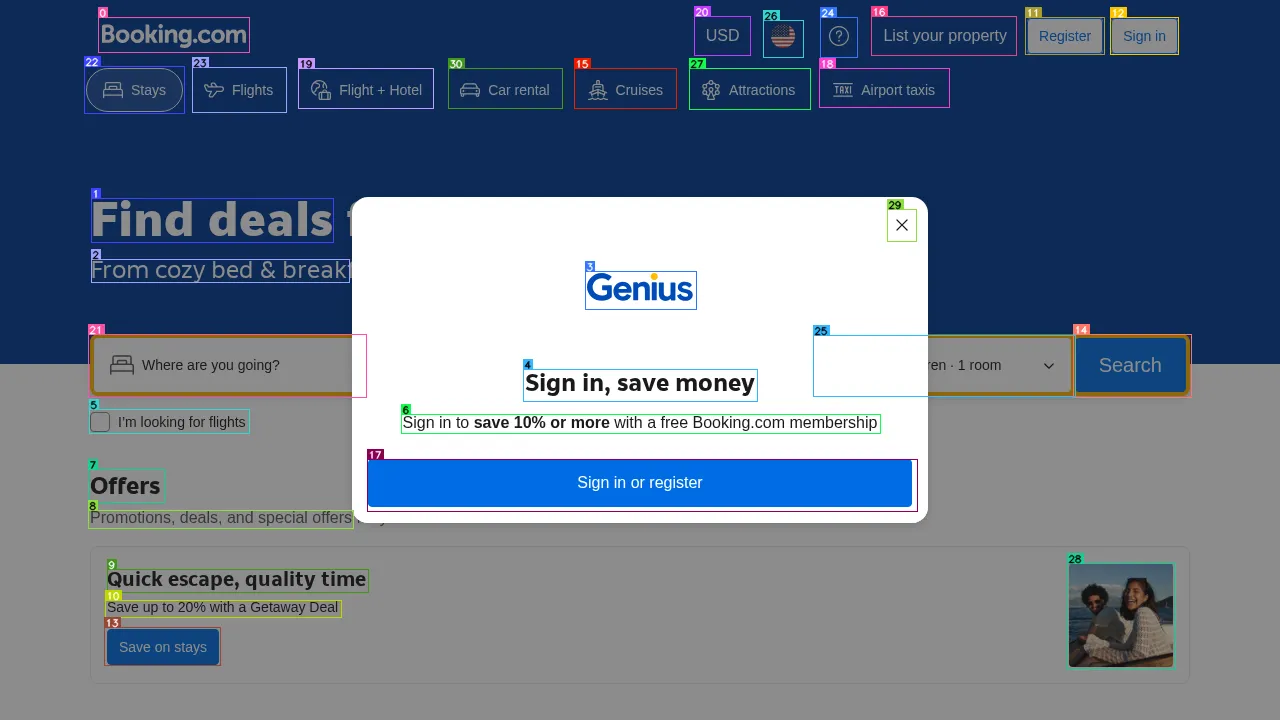

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 391, 'y': 222, 'interactivity': 'false', 'content': 'Find deals for any season.'}, {'x': 336, 'y': 271, 'interactivity': 'false', 'content': 'From cozy bed & breakfasts to luxury hotels'}, {'x': 169, 'y': 423, 'interactivity': 'false', 'content': "J I'm looking for flights."}, {'x': 126, 'y': 487, 'interactivity': 'false', 'content': 'Offers'}, {'x': 247, 'y': 518, 'interactivity': 'false', 'content': 'Promotions, deals, and special offers for you'}, {'x': 237, 'y': 580, 'interactivity': 'false', 'content': 'Quick escape, quality time.'}, {'x': 222, 'y': 608, 'interactivity': 'false', 'content': 'Save up to 20% with a Getaway Deal.'}, {'x': 924, 'y': 365, 'interactivity': 'true', 'content': '2 adults - 0 children - 1 room. '}, {'x': 1131, 'y': 364, 'interactivity': 'true', 'content': 'Search '

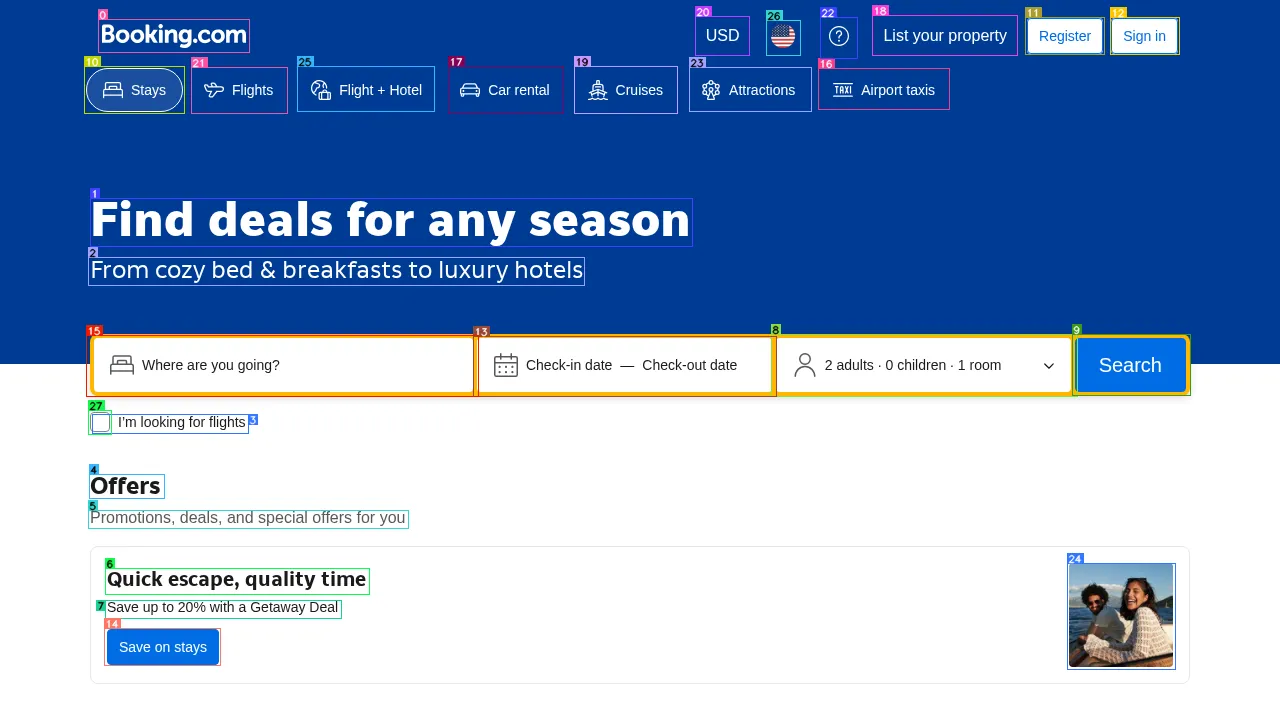

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports '}, {'x': 1144, 'y': 36, 'interactivity': 'true', 'conten

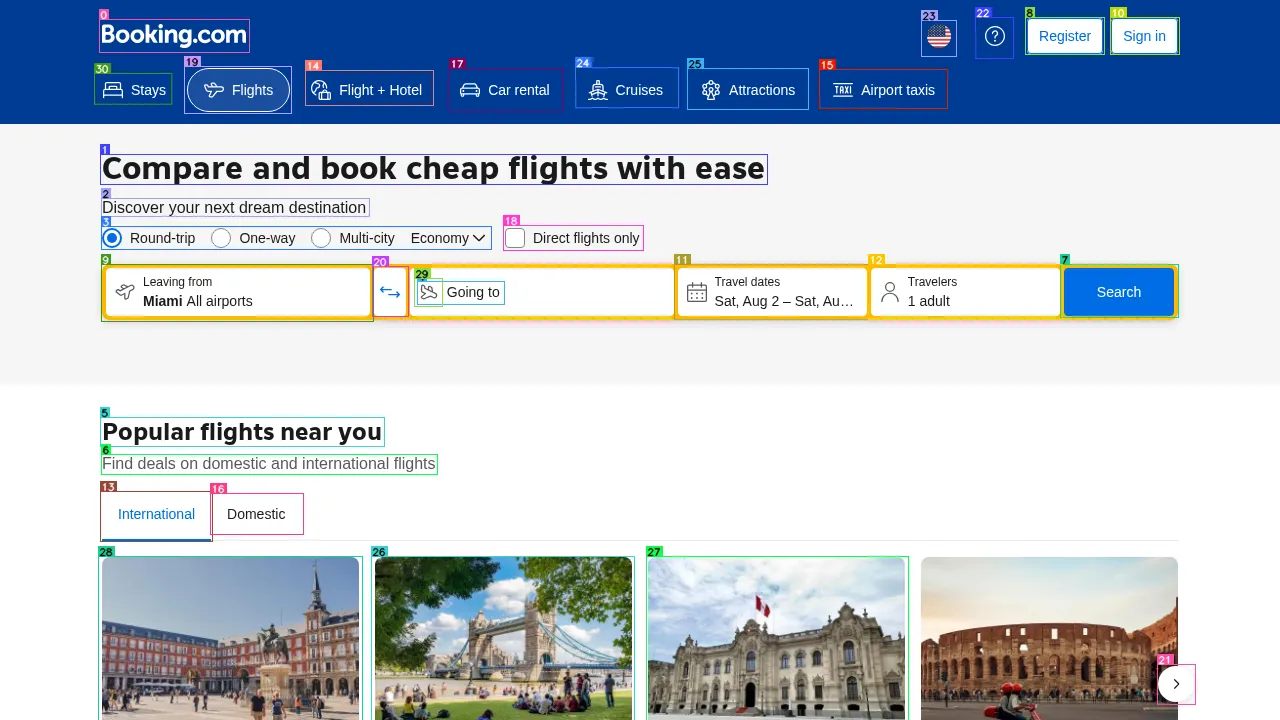

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports '}, {'x': 1144, 'y': 36, 'interactivity': 'true', 'conten

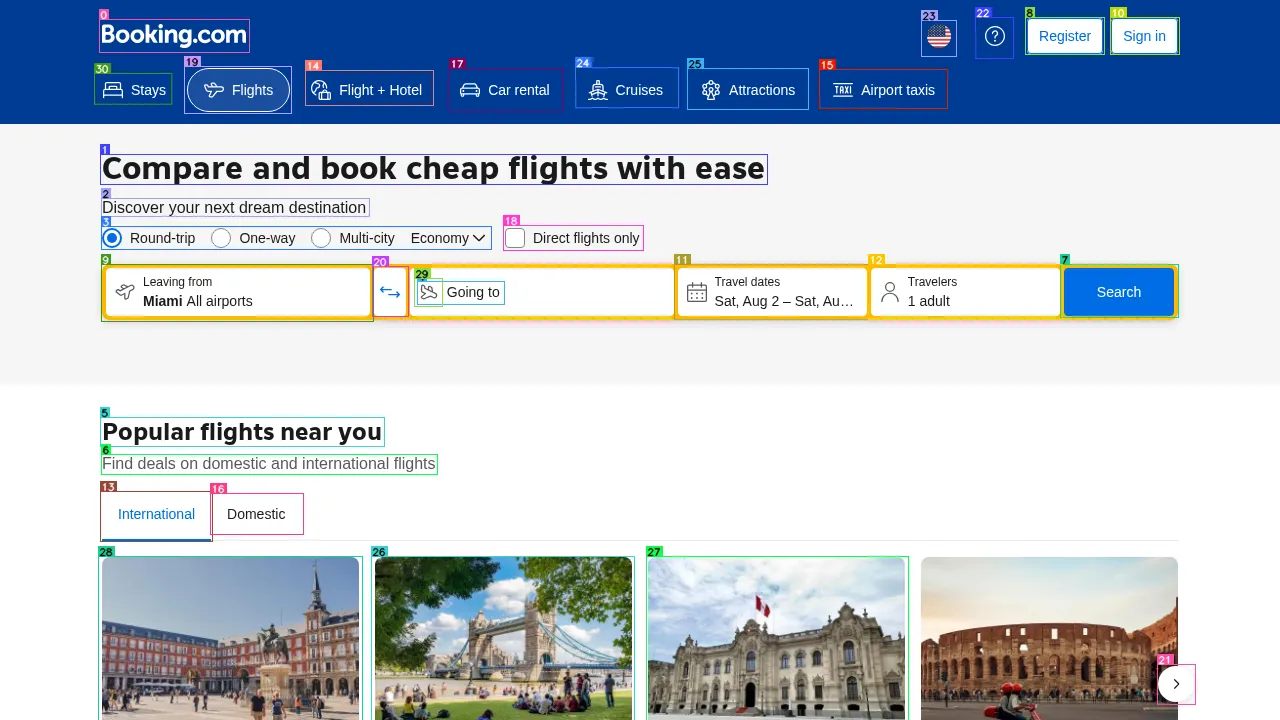

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports '}, {'x': 1144, 'y': 36, 'interactivity': 'true', 'conten

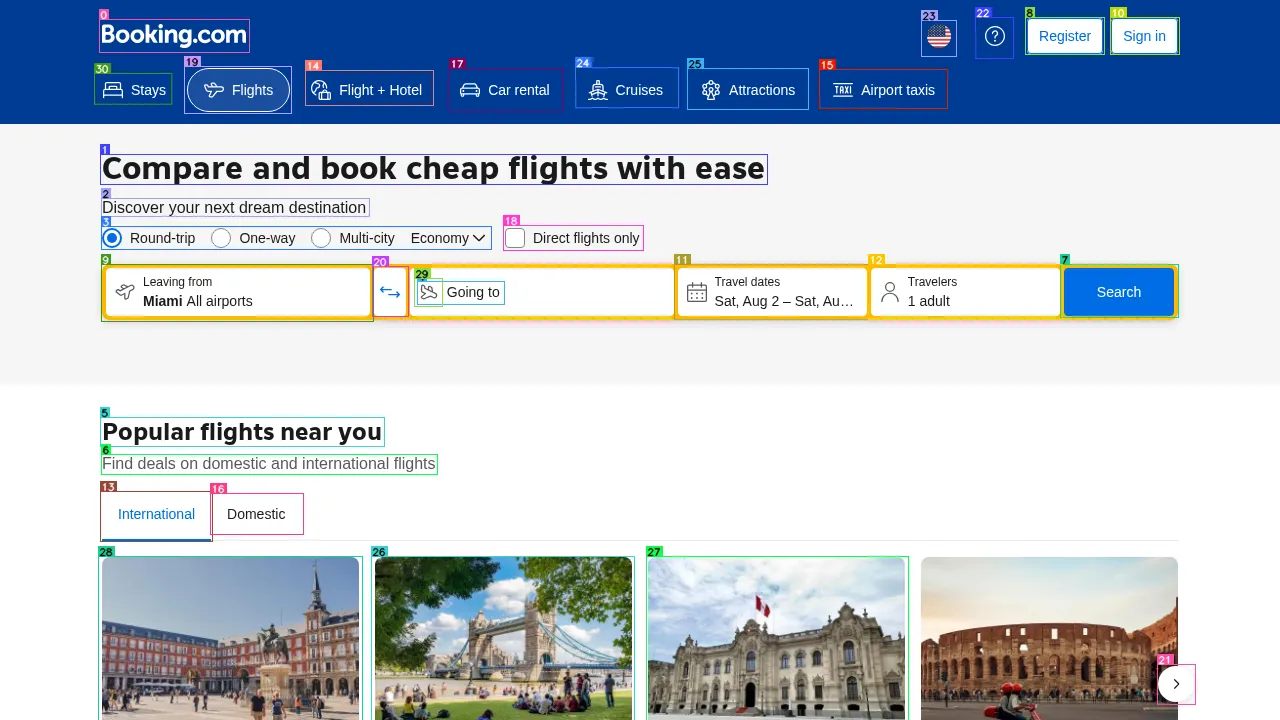

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports '}, {'x': 1144, 'y': 36, 'interactivity': 'true', 'conten

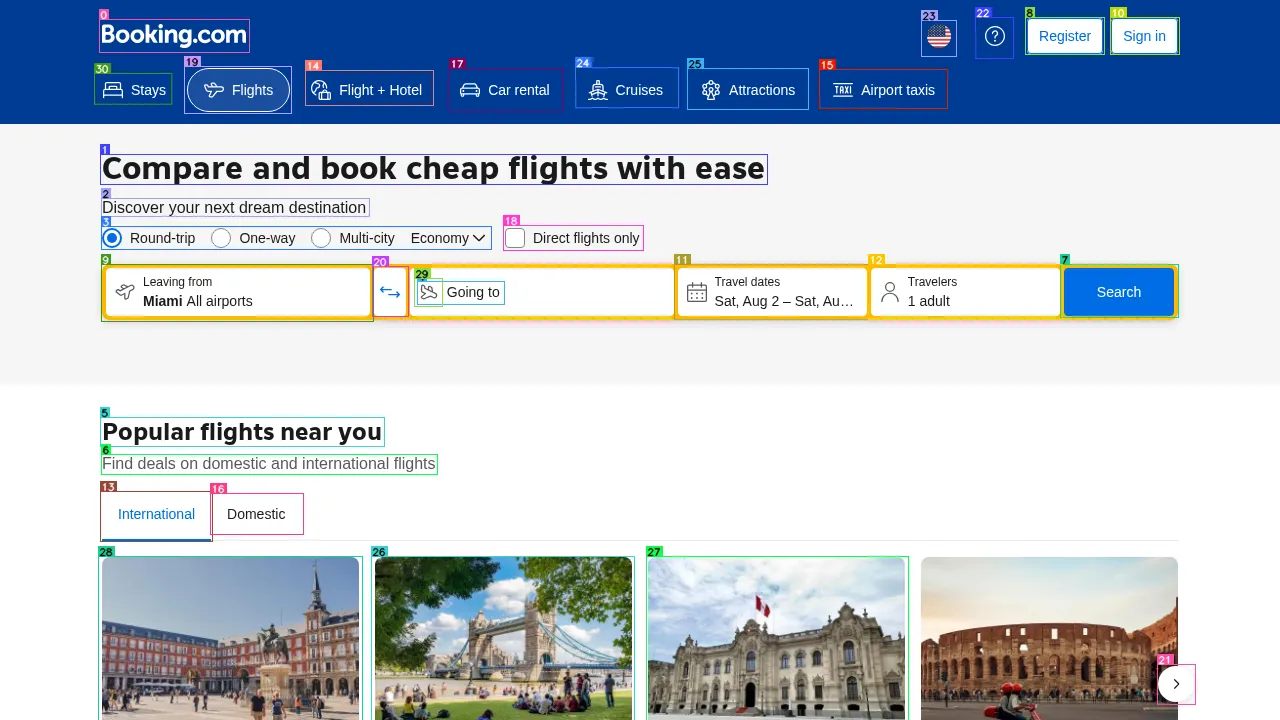

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports '}, {'x': 1144, 'y': 36, 'interactivity': 'true', 'conten

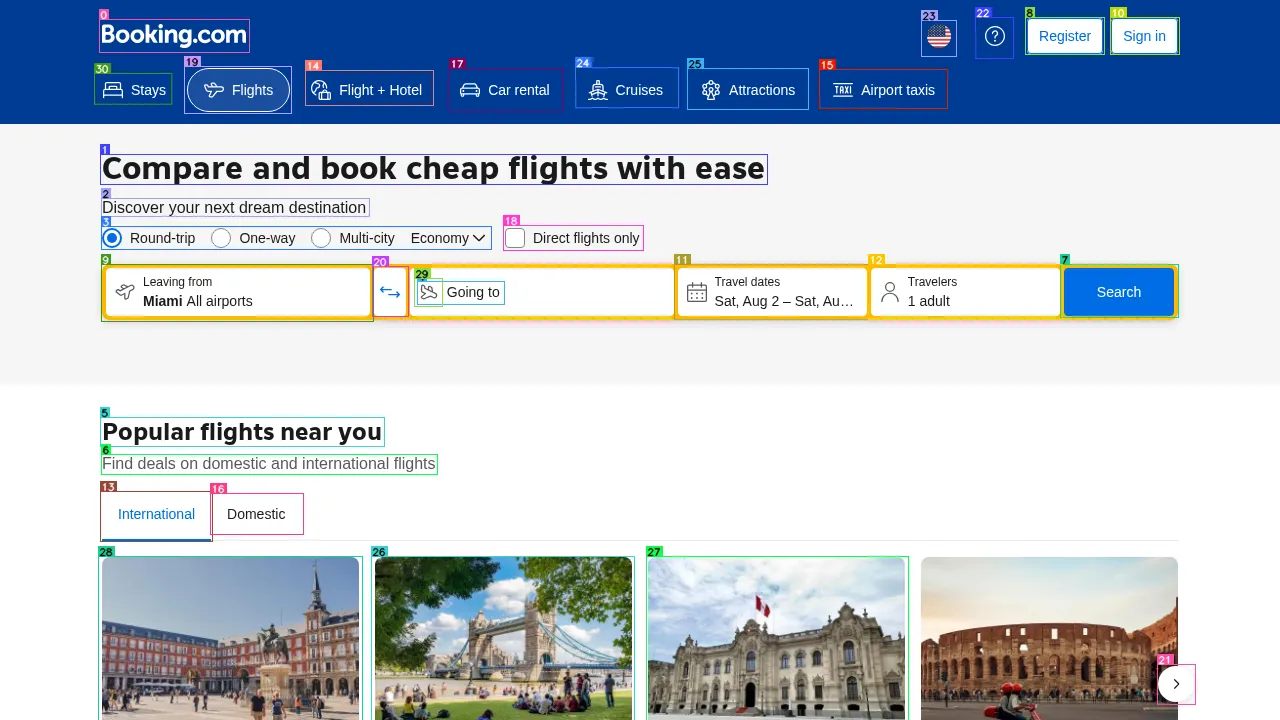

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 173, 'y': 36, 'interactivity': 'false', 'content': 'Booking.com'}, {'x': 433, 'y': 169, 'interactivity': 'false', 'content': 'Compare and book cheap flights with ease'}, {'x': 235, 'y': 207, 'interactivity': 'false', 'content': 'Discover your next dream destination.'}, {'x': 295, 'y': 237, 'interactivity': 'false', 'content': 'O Round-trip O One-way O Multi-city Economy'}, {'x': 460, 'y': 292, 'interactivity': 'false', 'content': 'Going to'}, {'x': 242, 'y': 432, 'interactivity': 'false', 'content': 'Popular flights near you.'}, {'x': 269, 'y': 464, 'interactivity': 'false', 'content': 'Find deals on domestic and international flights.'}, {'x': 1119, 'y': 291, 'interactivity': 'true', 'content': 'Search '}, {'x': 1064, 'y': 36, 'interactivity': 'true', 'content': 'Register '}, {'x': 237, 'y': 292, 'interactivity': 'true', 'content': 'Leaving from Miami All airports

CancelledError: 

In [15]:
res = await call_agent("from the booking.com website, go in the flight section enter departure city : Bologna and arrival city : Paris and search for flight.", page)
print(f"Final response: {res}")

In [16]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com/maps")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        #display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 387, 'y': 7, 'interactivity': 'false', 'content': '81'}, {'x': 461, 'y': 9, 'interactivity': 'false', 'content': 'OJohnson City'}, {'x': 82, 'y': 27, 'interactivity': 'false', 'content': 'ille'}, {'x': 693, 'y': 37, 'interactivity': 'false', 'content': 'oGreensboro'}, {'x': 178, 'y': 37, 'interactivity': 'false', 'content': 'Search Google Maps'}, {'x': 504, 'y': 73, 'interactivity': 'false', 'content': 'Hickoryo'}, {'x': 623, 'y': 65, 'interactivity': 'false', 'content': '85'}, {'x': 687, 'y': 67, 'interactivity': 'false', 'content': 'NORTH'}, {'x': 783, 'y': 69, 'interactivity': 'false', 'content': '-oRaleigh'}, {'x': 143, 'y': 91, 'interactivity': 'false', 'content': 'This area'}, {'x': 406, 'y': 91, 'interactivity': 'false', 'content': '81'}, {'x': 600, 'y': 91, 'interactivity': 'false', 'content': 'Mooresville'}, {'x': 686, 'y': 86, 'interactivity': 'false', 'content': 'CAROLINA'}, {'x': 905, 'y': 88, 'interactivity':

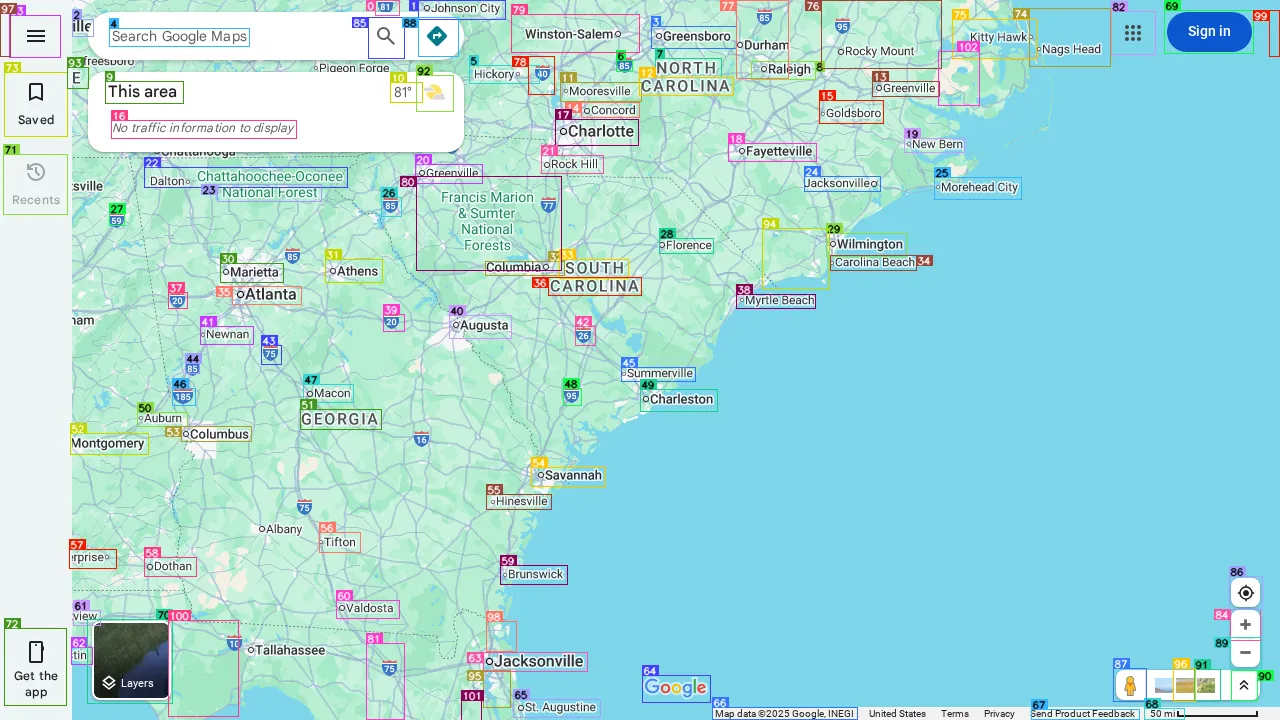

https://www.google.com/maps
Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 387, 'y': 7, 'interactivity': 'false', 'content': '81'}, {'x': 461, 'y': 9, 'interactivity': 'false', 'content': 'OJohnson City'}, {'x': 82, 'y': 27, 'interactivity': 'false', 'content': 'ille'}, {'x': 693, 'y': 37, 'interactivity': 'false', 'content': 'oGreensboro'}, {'x': 178, 'y': 37, 'interactivity': 'false', 'content': 'Search Google Maps'}, {'x': 504, 'y': 73, 'interactivity': 'false', 'content': 'Hickoryo'}, {'x': 623, 'y': 65, 'interactivity': 'false', 'content': '85'}, {'x': 687, 'y': 67, 'interactivity': 'false', 'content': 'NORTH'}, {'x': 783, 'y': 69, 'interactivity': 'false', 'content': '-oRaleigh'}, {'x': 143, 'y': 91, 'interactivity': 'false', 'content': 'This area'}, {'x': 406, 'y': 91, 'interactivity': 'false', 'content': '81'}, {'x': 600, 'y': 91, 'interactivity': 'false', 'content': 'Mooresville'}, {'x': 686, 'y': 86, 'interactivity': 'false', 'content': 'CAROLINA'}, {'x': 90

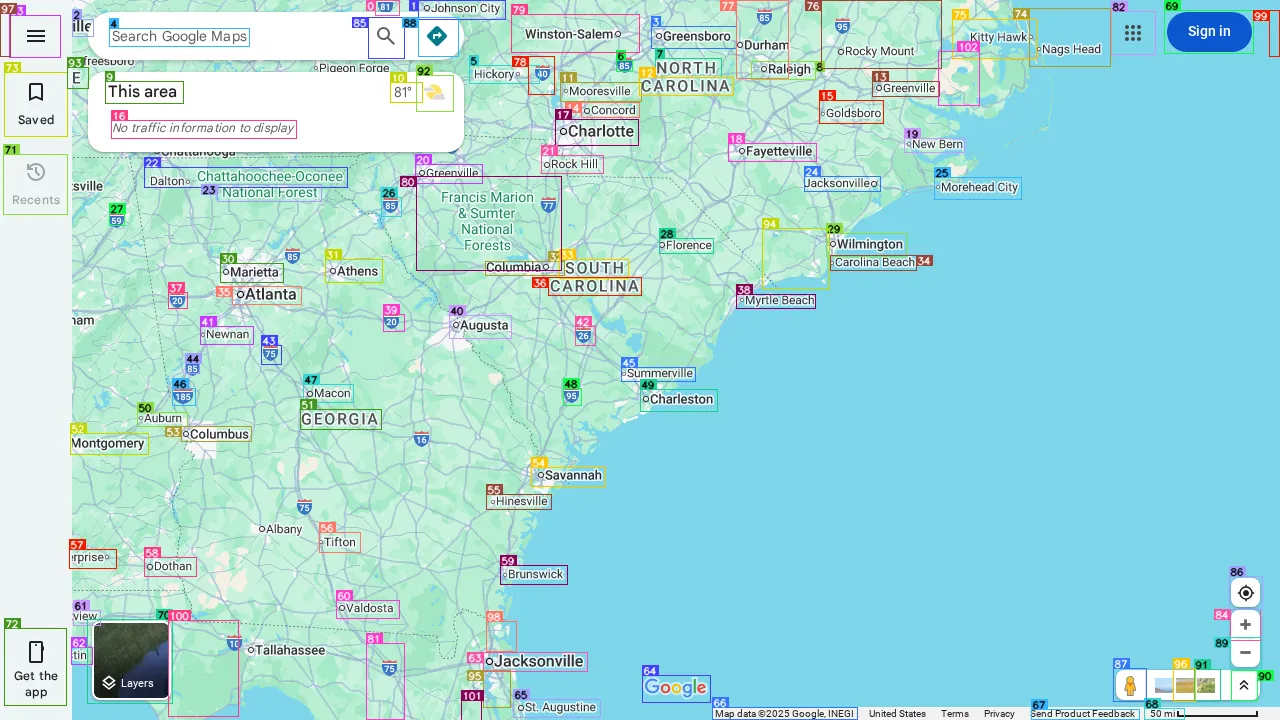

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 196, 'y': 191, 'interactivity': 'false', 'content': 'Add destination'}, {'x': 676, 'y': 687, 'interactivity': 'false', 'content': 'Google'}, {'x': 666, 'y': 713, 'interactivity': 'false', 'content': 'gle.GeoBasis-DE/BKG @2009'}, {'x': 130, 'y': 661, 'interactivity': 'true', 'content': 'OLayers '}, {'x': 1209, 'y': 32, 'interactivity': 'true', 'content': 'Sign in '}, {'x': 275, 'y': 96, 'interactivity': 'true', 'content': 'Bologna, Metropolitan City of Bologna, '}, {'x': 275, 'y': 144, 'interactivity': 'true', 'content': 'Paris, France '}, {'x': 302, 'y': 41, 'interactivity': 'true', 'content': '10 days '}, {'x': 353, 'y': 41, 'interactivity': 'true', 'content': '3 days '}, {'x': 153, 'y': 40, 'interactivity': 'true', 'content': 'Best '}, {'x': 401, 'y': 41, 'interactivity': 'true', 'content': '1h 45m '}, {'x': 253, 'y': 41, 'interactivity': 'true', 'content': '13 hr '}, {'x': 33, 'y': 294, 'interactivity': 'true', 'conten

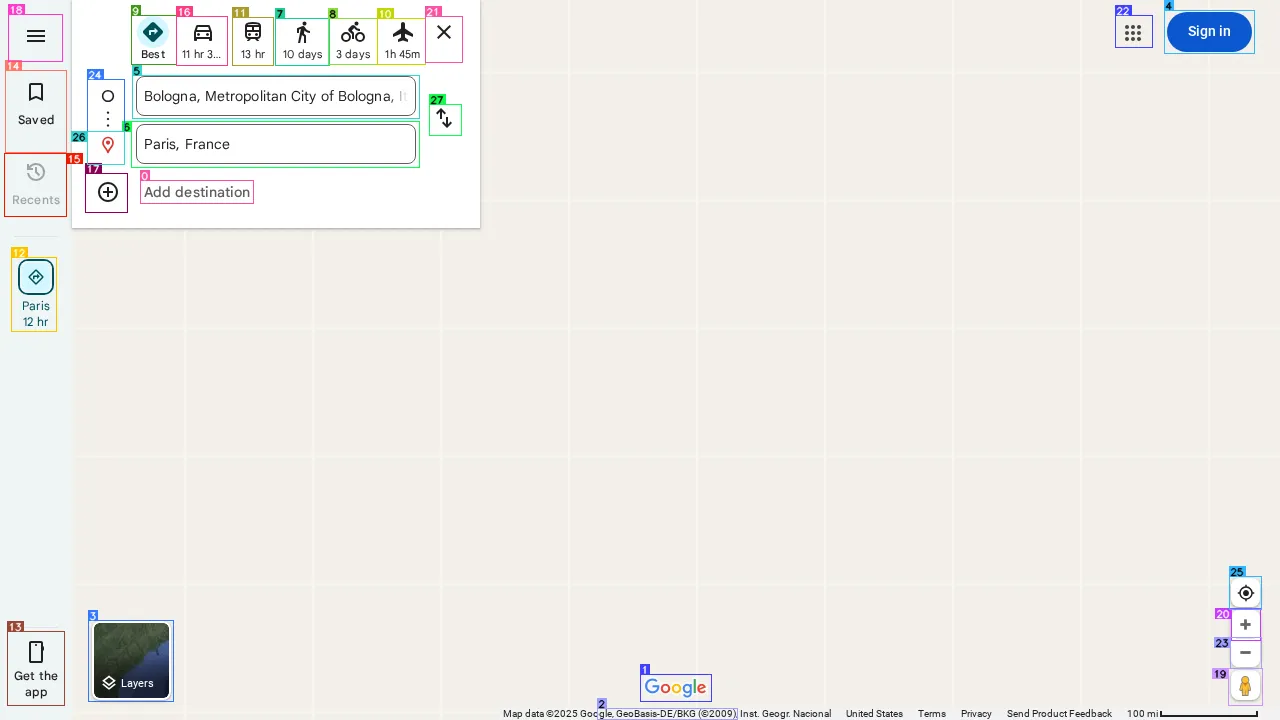

Loaded as API: https://microsoft-omniparser-v2.hf.space ✔
[{'x': 587, 'y': 17, 'interactivity': 'false', 'content': 'oLondon'}, {'x': 964, 'y': 37, 'interactivity': 'false', 'content': ' Gasd BJ EV charging>'}, {'x': 798, 'y': 65, 'interactivity': 'false', 'content': 'oBrussels'}, {'x': 913, 'y': 58, 'interactivity': 'false', 'content': 'oCologne'}, {'x': 208, 'y': 71, 'interactivity': 'false', 'content': 'Best travel modes'}, {'x': 518, 'y': 73, 'interactivity': 'false', 'content': 'oBournemouth'}, {'x': 781, 'y': 88, 'interactivity': 'false', 'content': 'Belgium'}, {'x': 834, 'y': 79, 'interactivity': 'false', 'content': 'oLiege'}, {'x': 268, 'y': 96, 'interactivity': 'false', 'content': 'Bologna, Metropolitan City of Bologna,'}, {'x': 997, 'y': 108, 'interactivity': 'false', 'content': 'Frankfurt'}, {'x': 996, 'y': 125, 'interactivity': 'false', 'content': 'am Main'}, {'x': 1249, 'y': 120, 'interactivity': 'false', 'content': 'oPrague'}, {'x': 844, 'y': 140, 'interactivity': 'false'

Thought: The distance between Bologna and Paris is shown as 1,109 km [46].
Action: ANSWER; 1,109 km
1. ToURL: ['https://www.google.com/maps']
2. Type: ['4', 'distance from Bologna to Paris']
3. Click: ['9']
4. ANSWER;: ['1,109 km']


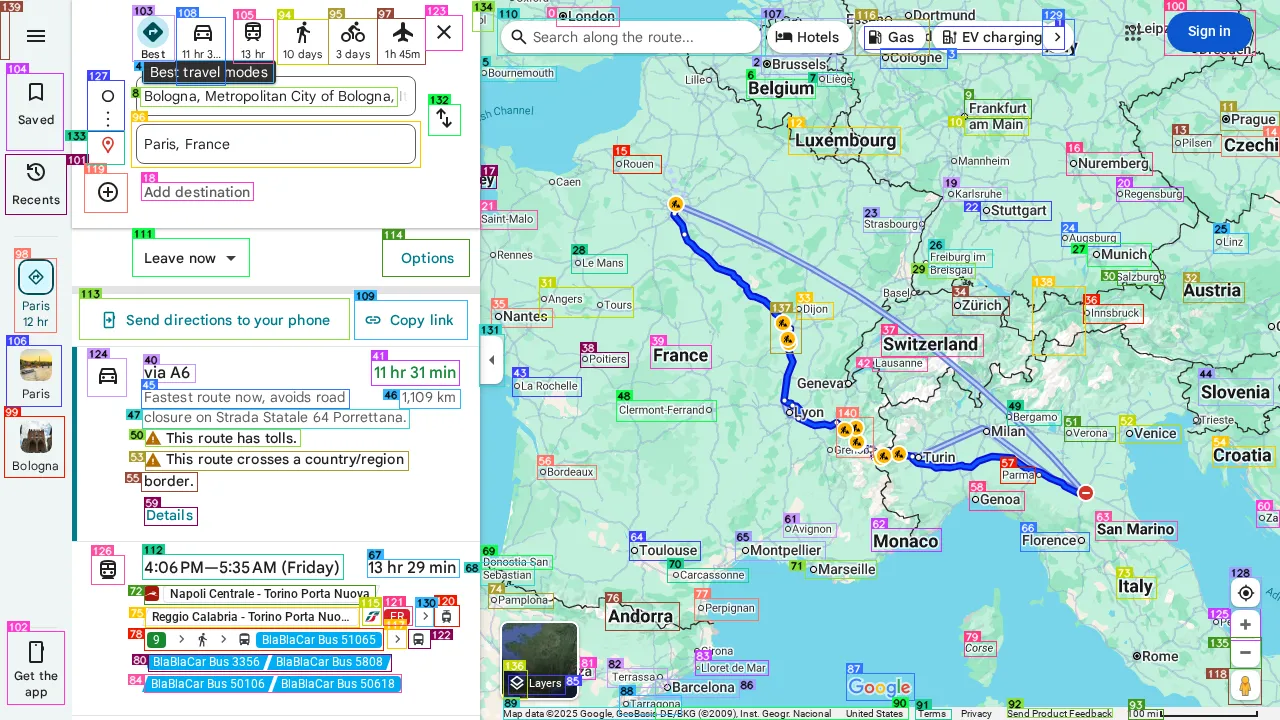

Final response: 1,109 km


In [17]:
res = await call_agent("tell me distance (Km) from Bologna to Paris.", page)
print(f"Final response: {res}")